#ME04

##Capítulo Datos

Este apartado, presenta la estructura de datos y la correspondiente adecuación para llevar a cabo el proyecto propuesto, con el análisis de las variables relevantes. Además, se realiza un análisis descriptivo de sus características para identificar las relaciones entre variables y seleccionar las más adecuadas para aplicar modelos de machine learning.

##1. Librerias y configuraciones previas



In [11]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#Outliers
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

#Creación de modelo
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#Transformación de variables
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

#Imputacion de genero
import gender_guesser.detector as gender

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#Ingesta de datos repositorio
import requests
import zipfile
import io
import os
import sys
import re

In [12]:


# Modificación: se agrega la query parameter raw=true para que GitHub entregue el contenido en bruto.
url_funcion = "https://github.com/Laurahrndz08/Modelo_Monografia/blob/main/utils.zip?raw=true"
response = requests.get(url_funcion)
zip_file = io.BytesIO(response.content)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Listar los archivos dentro del ZIP
        zip_ref.printdir()

        # Extraer todos los archivos en el directorio actual
        zip_ref.extractall("extracted_files")
sys.path.append(os.path.join(os.getcwd(), "extracted_files"))

File Name                                             Modified             Size
utils/                                         2024-11-02 07:05:02            0
utils/.ipynb_checkpoints/                      1980-01-01 00:00:00            0
utils/funciones.py                             2024-10-25 13:59:18         8608
utils/__init__.py                              2024-10-25 13:59:18            0
utils/__pycache__/                             2024-11-02 07:05:02            0
utils/__pycache__/funciones.cpython-312.pyc    2024-10-28 15:32:46         7778
utils/__pycache__/funciones.cpython-39.pyc     2024-10-25 13:59:18         5222
utils/__pycache__/utils.cpython-39.pyc         2024-10-25 13:59:18         3413
utils/__pycache__/__init__.cpython-312.pyc     2024-10-28 15:32:46          144
utils/__pycache__/__init__.cpython-39.pyc      2024-10-25 13:59:18          201


###2. Funciones adicionales para graficar

In [13]:
#reload(utils.funciones)
# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot

##3. Cargar el dataset

###3.1 Datos originales

Los datos usados corresponden a los clientes actuales de Territorio Previsión, se extrajo desde la BBDD de la compañía por SQL server desde un periodo comprendido entre 01 de enero de 2023 hasta 31 de diciembre de 2023. El dataset, fue construido mediante la unión de diversas tablas considerando algunas variables entre las cuales se encuentran: la edad, número de pagos, el mecanismo de pago, la composición del producto actual y la zona geográfica. Cada una de las variables seleccionadas, no hacen relación a información sensible mitigando el riesgo de tratamiento de datos dado a la naturaleza del negocio, Asimismo, se trabajará desde un archivo de formato CSV dado que la BBDD es transaccional y esto garantiza trabajar con los datos reales de ese periodo y que no sean afectados por cambios.

Este contiene un total 57.461 registros y 29 columnas de información tanto cuantitativas como cualitativas. Cada registro representa un titular por contrato creado en el periodo descrito, y cada columna hace relación a características de comportamientos del cliente y producto.


In [14]:
#Ingesta de datos desde repositorio
# ==========================================================
archivo = 'https://github.com/Laurahrndz08/Modelo_Monografia/blob/main/Base_Monografia.csv?raw=true' # Updated URL to get raw data
df = pd.read_csv(archivo, sep =';')
print(f"Total registros: {len(df)}")


Total registros: 57461


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57461 entries, 0 to 57460
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               57461 non-null  object 
 1   Poliza_Grupal                       57461 non-null  int64  
 2   Id_Titular                          57461 non-null  int64  
 3   Contrato                            57461 non-null  int64  
 4   Estado                              57378 non-null  object 
 5   Genero                              23019 non-null  object 
 6   Primer_nombre                       57451 non-null  object 
 7   Edad_Titular                        57015 non-null  float64
 8   Ingreso_Titular                     57461 non-null  object 
 9   Municipio                           57461 non-null  object 
 10  Forma_pago                          57461 non-null  int64  
 11  Vigencia_del_contrato               57461

In [16]:
# Función para limpiar el nombre
def limpiar_nombre(nombre):
    if isinstance(nombre, str): #DECIRLE QUE ES TEXTO
        # Convertir el nombre a minúsculas
        nombre = nombre.lower()

        # Eliminar caracteres especiales
        nombre = re.sub(r'[^a-záéíóúüñ\s]', '', nombre)  # Permite letras, acentos y espacios

        return nombre
    else:
        return nombre

df['Primer_nombre'] = df['Primer_nombre'].apply(limpiar_nombre)


In [17]:
def formatear_nombre(nombre):
# LE DIGO QUE ES TEXTO
    if isinstance(nombre, str):
#sE PARO LOS NOMBRES POR CARACTERES PARA QUE SEPA QUE LA PRIMERA SE VUELVE MAYUSCULA Y EL RESTO MINUSCULA
        Letras = nombre.split()

        # MAYUS PRIMERA
        Letras_formateadas = [Letras.capitalize() for Letras in Letras]

        # Unir las LETRAS
        return " ".join(Letras_formateadas)
    else:
        return nombre
df['Primer_nombre'] = df['Primer_nombre'].apply(formatear_nombre)



In [18]:

import pandas as pd

# inicializarlo
d = gender.Detector()
def obtener_genero(nombre):
    gender_result = d.get_gender(nombre)
    return gender_result

# Como el genero viene en cuatro posibles respuestas si cambia a lo que necesita el dataset
def convertir_genero(genero):
    if genero == 'male':
        return 'M'
    elif genero == 'female':
        return 'F'
    elif genero == 'mostly_male':
        return 'M'
    elif genero == 'mostly_female':
        return 'F'
    elif genero == 'andy': #Es para nombre unisex asi que no le identifica el genero
        return 'NULL'
    elif genero == 'unknown': #no estan en su libreria
        return 'NULL'
    else:
        return genero


df.loc[df['Genero'].isnull(), 'Genero'] = df.loc[df['Genero'].isnull(), 'Primer_nombre'].apply(obtener_genero)

# Convertir el género a 'm' o 'f'
df['Genero'] = df['Genero'].apply(convertir_genero)

# Mostrar solo las columnas 'Primer_nombre' y 'Genero'
print(df[['Primer_nombre', 'Genero']])



      Primer_nombre Genero
0             Jaime      M
1         Elizabeth      F
2             Mateo      M
3              Juan      M
4             Laura      F
...             ...    ...
57456       Julieth   NULL
57457      Carolina      F
57458     Sanmartin   NULL
57459          Luis      M
57460        Sergio      M

[57461 rows x 2 columns]


In [19]:
#Evaluamos como quedo
print(df.groupby('Genero').Genero.count().sort_values(ascending=False))

Genero
M       25998
F       23374
NULL     8089
Name: Genero, dtype: int64


In [20]:
# VER LOS NOMBRES QUE NO IDENTIFICO
valores_null = df[df['Genero']=='NULL']
valores_null = valores_null.drop_duplicates()
# Mostrar los resultados
print(valores_null[['Primer_nombre', 'Genero']])

      Primer_nombre Genero
118         Agudelo   NULL
174         Edilson   NULL
242          Jaison   NULL
250         Bleidis   NULL
266           Duban   NULL
...             ...    ...
57429     Ana Maria   NULL
57431       Jonatan   NULL
57441       Carolai   NULL
57456       Julieth   NULL
57458     Sanmartin   NULL

[8089 rows x 2 columns]


In [21]:
df = df[df['Genero'] != 'NULL']

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49372 entries, 0 to 57460
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               49372 non-null  object 
 1   Poliza_Grupal                       49372 non-null  int64  
 2   Id_Titular                          49372 non-null  int64  
 3   Contrato                            49372 non-null  int64  
 4   Estado                              49315 non-null  object 
 5   Genero                              49372 non-null  object 
 6   Primer_nombre                       49366 non-null  object 
 7   Edad_Titular                        49047 non-null  float64
 8   Ingreso_Titular                     49372 non-null  object 
 9   Municipio                           49372 non-null  object 
 10  Forma_pago                          49372 non-null  int64  
 11  Vigencia_del_contrato               49372 non-

##3.2 Dataset

Forma en que se seleccionaron los datos, la división de los mismos
* Imputación de faltantes
* Escalado y normalización
* Metodologías de uso para calcular los outliers





In [23]:
'''
Se anexa archivo con información de municipios de Colombia para unificarlos por tipo de ubicación
geográfica (rural/urbana), la fuente de información del archivo es la DIAN.

1. Se verifica y eliminan duplicados en la columna 'Municipio' del DataFrame (DF) 'municipio',
2. Se ejecuta un merge entre ambos DF y se adiciona la columna 'tipo_geografia'
'''
ruta_municipio = "https://github.com/Laurahrndz08/Modelo_Monografia/blob/main/municipios.csv?raw=true"
municipio = pd.read_csv(ruta_municipio, sep =';')
municipio.info()
#print(f"Total registros: {len(municipio)}")

municipio = municipio.drop_duplicates(subset=['Municipio'], keep='first')
municipio.info()
df = pd.merge(df, municipio, on='Municipio', how='left', validate='many_to_one')

# Mostrar el DataFrame resultante
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Municipio       753 non-null    object
 1   tipo_geografia  753 non-null    object
dtypes: object(2)
memory usage: 11.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 727 entries, 0 to 752
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Municipio       727 non-null    object
 1   tipo_geografia  727 non-null    object
dtypes: object(2)
memory usage: 17.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49372 entries, 0 to 49371
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               49372 non-null  object 
 1   Poliza_Grupal                       49372 non-null  in

In [24]:
#Se valida el motivo de datos faltantes en la nueva columna del dataset
df['tipo_geografia'].unique()

array(['Urbano', 'rural', nan], dtype=object)

In [25]:
'''
Se identifican los registros correspondientes a municipios que 'no existen'
en la DIAN y por ser 12 registros no signifitivos para la muestra, se eliminan del dataset
'''
df[df['tipo_geografia'].isna()].head(12)

,Canal,Poliza_Grupal,Id_Titular,Contrato,Estado,Genero,Primer_nombre,Edad_Titular,Ingreso_Titular,Municipio,...,Casado,Beneficiario,Mascotas,Exequial_Personas,Auxilio,Asistencia_Personas,Total_prima_mes,PQRS,Comunicación,tipo_geografia
892,Asociadas,554,139794638,373747,No Renovo,M,Edgar,35.0,13/01/2023,Simacota,...,1,0,0,5,0,0,6600,0,0,NaN
7630,Asociadas,501,107087387,389143,No Renovo,F,Deisy,22.0,20/06/2023,Fuentedeoro,...,0,0,0,1,0,0,1500,0,0,NaN
9403,Asociadas,578,164766125,391637,No Renovo,M,Jorge,35.0,24/07/2023,El Piñón,...,0,0,0,1,1,0,2350,0,0,NaN
10978,Asociadas,501,161887925,394667,No Renovo,F,Ana,49.0,12/09/2023,Fuentedeoro,...,0,0,0,1,0,0,1500,0,0,NaN
16695,Asociadas,12,125622598,10449091,No Renovo,F,Maribel,37.0,5/01/2023,Castilla La Nueva,...,0,0,0,1,1,0,6000,0,0,NaN
21560,Corporativo,265,129499177,10455633,No Renovo,M,Luis,33.0,22/02/2023,Junín,...,0,0,0,1,1,1,4100,0,0,NaN
26503,Asociadas,30,157811811,10462498,No Renovo,M,Alvaro,81.0,17/04/2023,Florida,...,1,0,0,5,0,0,10300,0,0,NaN
26705,Corporativo,638,151449654,10462749,No Renovo,M,Roger,39.0,18/04/2023,Colosó,...,0,0,0,1,1,1,8300,0,0,NaN
26714,Corporativo,638,160789700,10462759,No Renovo,F,Valentina,24.0,18/04/2023,Quetame,...,0,0,0,1,1,1,8300,0,0,NaN
42407,Corporativo,647,169611196,10484707,No Renovo,M,Walter,34.0,6/10/2023,Bagadó,...,0,0,0,1,0,0,1800,0,0,NaN


In [26]:
#Eliminación de datos nan para municipios
df = df.drop(df[df['tipo_geografia'].isna()].index)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49362 entries, 0 to 49371
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               49362 non-null  object 
 1   Poliza_Grupal                       49362 non-null  int64  
 2   Id_Titular                          49362 non-null  int64  
 3   Contrato                            49362 non-null  int64  
 4   Estado                              49305 non-null  object 
 5   Genero                              49362 non-null  object 
 6   Primer_nombre                       49356 non-null  object 
 7   Edad_Titular                        49037 non-null  float64
 8   Ingreso_Titular                     49362 non-null  object 
 9   Municipio                           49362 non-null  object 
 10  Forma_pago                          49362 non-null  int64  
 11  Vigencia_del_contrato               49362 non-

In [27]:
#Se unifican las categorías para una posterior conversión a variables dummy
df.replace({'Canal' : {'Sedes Alternas Apartadó': 'Sedes_intermediarios',
                                'Sedes Alternas':'Sedes_intermediarios',
                                'Intermediarios de Previsión':'Sedes_intermediarios'}}, inplace=True)

In [28]:
#Eliminación de datos nan para edad
df = df.drop(df[df['Edad_Titular'].isna()].index)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49037 entries, 0 to 49371
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               49037 non-null  object 
 1   Poliza_Grupal                       49037 non-null  int64  
 2   Id_Titular                          49037 non-null  int64  
 3   Contrato                            49037 non-null  int64  
 4   Estado                              48980 non-null  object 
 5   Genero                              49037 non-null  object 
 6   Primer_nombre                       49034 non-null  object 
 7   Edad_Titular                        49037 non-null  float64
 8   Ingreso_Titular                     49037 non-null  object 
 9   Municipio                           49037 non-null  object 
 10  Forma_pago                          49037 non-null  int64  
 11  Vigencia_del_contrato               49037 non-

In [29]:
#Lista de variables categóricas
catCols = df.select_dtypes(include = ['object', 'category']).columns.tolist()

#Se elimina la columna estado de la lista de variables Categóricas ya que es nuestra variable de salida
columns_to_remove = ['Estado', 'Municipio', 'Id_Titular', 'Ingreso_Titular', 'Fecha_Renovacion_Actual', 'Primer_nombre']
catCols = [col for col in catCols if col not in columns_to_remove]

print(df[catCols].info())

<class 'pandas.core.frame.DataFrame'>
Index: 49037 entries, 0 to 49371
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Canal           49037 non-null  object
 1   Genero          49037 non-null  object
 2   Metodo_Pago     49037 non-null  object
 3   tipo_geografia  49037 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


In [30]:
#Distribución de la variable genero
print(df.groupby('Genero').Genero.count().sort_values(ascending=False))

Genero
M    25833
F    23204
Name: Genero, dtype: int64


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49037 entries, 0 to 49371
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               49037 non-null  object 
 1   Poliza_Grupal                       49037 non-null  int64  
 2   Id_Titular                          49037 non-null  int64  
 3   Contrato                            49037 non-null  int64  
 4   Estado                              48980 non-null  object 
 5   Genero                              49037 non-null  object 
 6   Primer_nombre                       49034 non-null  object 
 7   Edad_Titular                        49037 non-null  float64
 8   Ingreso_Titular                     49037 non-null  object 
 9   Municipio                           49037 non-null  object 
 10  Forma_pago                          49037 non-null  int64  
 11  Vigencia_del_contrato               49037 non-

##3.2.1 Creación de modelo de ML para la imputación de valores a la variable género

Se utiliza cómo técnica de imputación de valores nulos para la variable 'Genero', la implementación de un modelo de ML.

Se decide el uso de ésta técnica, dado que las otras generalmente utilizadas para este tipo de casos, implicarían la posibidad de descartar más de la mitad del dataset.

El dataset original tiene un total de 57449 datos, sin embargo el género
tiene 34436 datos faltantes, de ahí que se implementará un modelo de ML
(Regresión Logística) para imputar los datos faltantes.

A continuación se describen las actividades del proceso de la creación e implementación del modelo.
1. Creación de un DF para la predicción de los valores de género
2. Eliminación de valores nulos en columnas del nuevo DF
3. Se eliminan variables del DF original, que no tienen importancia real en la
predicción del género y hacen más complejo el modelo para la predicción
4. Se convierten variables categóricas en variables dummy y se escalan variables numéricas
5. Se realiza la predicción con el modelo y se imputan los valores correspondientes

##3.3 Analítica descriptiva

Validación de la relación entre la variables

*Análisis de los outliers

In [32]:
df = df.dropna ()
print(f"Total registros: {len(df)}")
print(df.info())  # Verificar lo que se monto

Total registros: 48977
<class 'pandas.core.frame.DataFrame'>
Index: 48977 entries, 0 to 49371
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               48977 non-null  object 
 1   Poliza_Grupal                       48977 non-null  int64  
 2   Id_Titular                          48977 non-null  int64  
 3   Contrato                            48977 non-null  int64  
 4   Estado                              48977 non-null  object 
 5   Genero                              48977 non-null  object 
 6   Primer_nombre                       48977 non-null  object 
 7   Edad_Titular                        48977 non-null  float64
 8   Ingreso_Titular                     48977 non-null  object 
 9   Municipio                           48977 non-null  object 
 10  Forma_pago                          48977 non-null  int64  
 11  Vigencia_del_contrato  

In [33]:
#Cambios en la data para dumificar usando metodologia label encoding y one hot encoding

#One hot encoding para genero y tipo geografia
df = pd.get_dummies(df, columns=['Genero', 'tipo_geografia'], drop_first=False)

#Label encoding para metodo de pago por estructura del negocio
df['Metodo_Pago'] = df['Metodo_Pago'].replace({'Factura': 1, 'Cuenta de cobro': 1,'Convenio': 1,'Pago en Caja': 0,'Débito Automático': 2,'Descuento de nómina': 2,'Tarjeta crédito': 2}).astype(int)




In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48977 entries, 0 to 49371
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               48977 non-null  object 
 1   Poliza_Grupal                       48977 non-null  int64  
 2   Id_Titular                          48977 non-null  int64  
 3   Contrato                            48977 non-null  int64  
 4   Estado                              48977 non-null  object 
 5   Primer_nombre                       48977 non-null  object 
 6   Edad_Titular                        48977 non-null  float64
 7   Ingreso_Titular                     48977 non-null  object 
 8   Municipio                           48977 non-null  object 
 9   Forma_pago                          48977 non-null  int64  
 10  Vigencia_del_contrato               48977 non-null  int64  
 11  Numero_de_pagos                     48977 non-

In [35]:
#Lista de variables numéricas
numCols=df.select_dtypes(include = ['int64']).columns.tolist()


columns_num_to_remove = ['Casado', 'Poliza_Grupal', 'Contrato','Id_Titular','Metodo_Pago']
numCols = [col for col in numCols if col not in columns_num_to_remove]
print(df[numCols].info())

<class 'pandas.core.frame.DataFrame'>
Index: 48977 entries, 0 to 49371
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Forma_pago                          48977 non-null  int64
 1   Vigencia_del_contrato               48977 non-null  int64
 2   Numero_de_pagos                     48977 non-null  int64
 3   Valor_Pagado                        48977 non-null  int64
 4   periocidad_cambiante                48977 non-null  int64
 5   Numero_recompras_o_renovacion       48977 non-null  int64
 6   Contratos_activos_anteriores        48977 non-null  int64
 7   Valor_Contratos_activos_anteriores  48977 non-null  int64
 8   Beneficiario                        48977 non-null  int64
 9   Mascotas                            48977 non-null  int64
 10  Exequial_Personas                   48977 non-null  int64
 11  Auxilio                             48977 non-null  int64
 12  Asistenci

In [36]:
print(df.groupby('Estado').Estado.count().sort_values(ascending=False))

Estado
Renovo       32098
No Renovo    16879
Name: Estado, dtype: int64


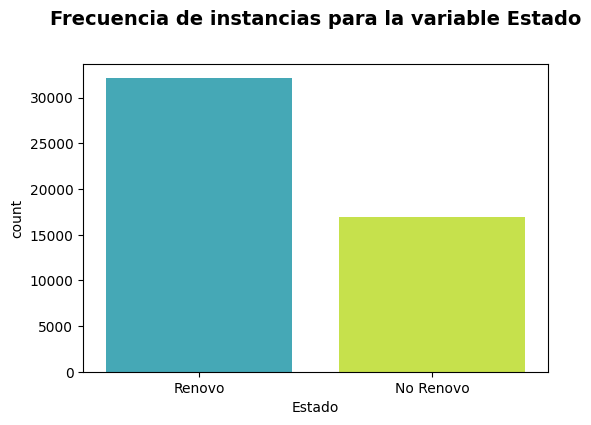

In [37]:
multiple_plot(1, df , None, 'Estado', 'countplot', 'Frecuencia de instancias para la variable Estado',0)

In [38]:
#Se vuelven a en listar las variables categóricas, despues de la dummies
catCols = df.select_dtypes(include = ['object', 'category','bool']).columns.tolist()

#Se elimina la columna estado de la lista de variables Categóricas ya que es nuestra variable de salida
columns_to_remove = ['Estado', 'Municipio', 'Id_Titular', 'Ingreso_Titular', 'Fecha_Renovacion_Actual', 'Primer_nombre']
catCols = [col for col in catCols if col not in columns_to_remove]

print(df[catCols].info())

<class 'pandas.core.frame.DataFrame'>
Index: 48977 entries, 0 to 49371
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Canal                  48977 non-null  object
 1   Genero_F               48977 non-null  bool  
 2   Genero_M               48977 non-null  bool  
 3   tipo_geografia_Urbano  48977 non-null  bool  
 4   tipo_geografia_rural   48977 non-null  bool  
dtypes: bool(4), object(1)
memory usage: 956.6+ KB
None


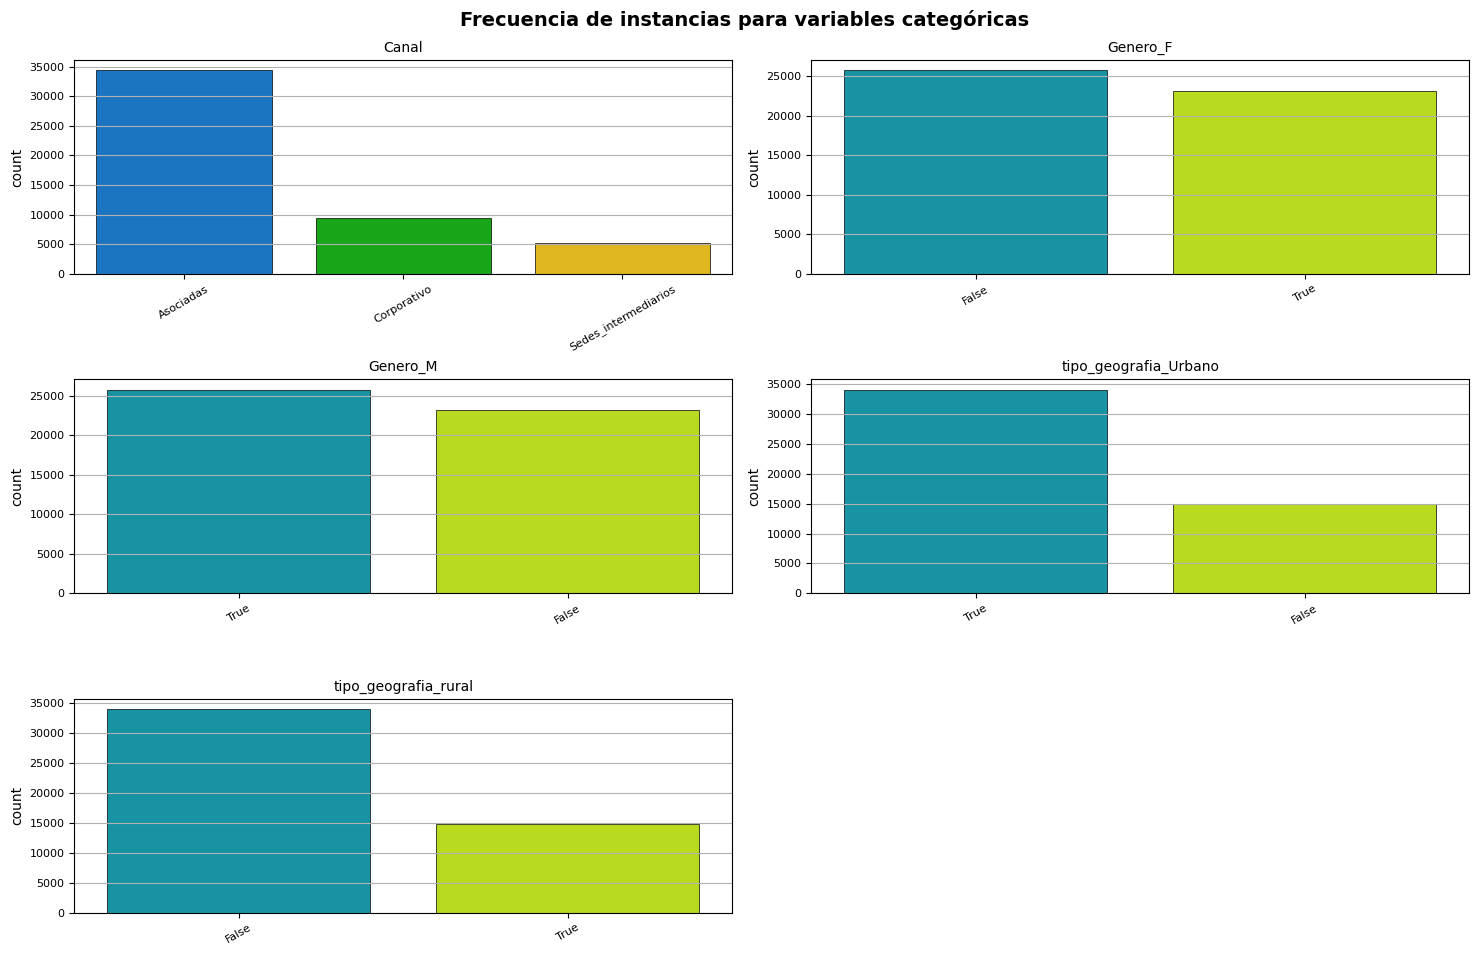

In [39]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(2, df , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [40]:

for col in catCols:
   print("="*5 + f" {col} " + "="*20)
   print(df[col].value_counts())
   print()

===== Canal ====================
Canal
Asociadas               34394
Corporativo              9401
Sedes_intermediarios     5182
Name: count, dtype: int64

===== Genero_F ====================
Genero_F
False    25785
True     23192
Name: count, dtype: int64

===== Genero_M ====================
Genero_M
True     25785
False    23192
Name: count, dtype: int64

===== tipo_geografia_Urbano ====================
tipo_geografia_Urbano
True     34094
False    14883
Name: count, dtype: int64

===== tipo_geografia_rural ====================
tipo_geografia_rural
False    34094
True     14883
Name: count, dtype: int64



In [41]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numCols])

param_grid = {'n_neighbors': [5, 10, 15, 20, 25]}
lof = LocalOutlierFactor()

grid_search = GridSearchCV(lof, param_grid, cv=5, scoring='f1_micro')
grid_search.fit(X_scaled)  # Donde X es tu conjunto de datos
print("Mejor número de vecinos:", grid_search.best_params_)

Mejor número de vecinos: {'n_neighbors': 5}


In [42]:
#utilización de LocalOutlierFactor con 5 vecinos para identificar valores atípicos en las variables de entrada

lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)

y_pred = lof.fit_predict(df[numCols])
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())

Indices de valores atípicos:  [25, 31, 33, 52, 58, 73, 74, 85, 86, 111, 131, 133, 137, 138, 142, 168, 185, 203, 245, 247, 252, 260, 263, 264, 271, 280, 287, 290, 298, 299, 302, 305, 317, 327, 331, 332, 335, 338, 346, 350, 356, 361, 367, 369, 379, 384, 388, 389, 395, 410, 417, 419, 434, 483, 500, 508, 521, 523, 545, 560, 568, 574, 579, 586, 589, 590, 594, 595, 596, 605, 613, 615, 621, 640, 643, 649, 653, 658, 669, 670, 675, 676, 681, 696, 697, 699, 703, 723, 724, 727, 733, 736, 742, 743, 744, 751, 760, 765, 768, 772, 773, 775, 790, 791, 799, 802, 818, 856, 888, 893, 901, 902, 943, 945, 950, 974, 975, 1018, 1026, 1032, 1054, 1058, 1069, 1073, 1079, 1082, 1093, 1107, 1108, 1111, 1114, 1117, 1118, 1130, 1132, 1134, 1153, 1165, 1169, 1173, 1181, 1188, 1190, 1214, 1218, 1221, 1224, 1247, 1249, 1250, 1253, 1280, 1287, 1289, 1292, 1293, 1297, 1300, 1303, 1326, 1327, 1329, 1341, 1342, 1343, 1356, 1358, 1362, 1382, 1385, 1420, 1442, 1448, 1464, 1475, 1495, 1503, 1507, 1530, 1541, 1543, 1556, 156

In [43]:
# Eliminar los valores atípicos del dataframe original
df = df.loc[~outliers]

print(f"Total registros: {len(df)}")

Total registros: 44079


In [44]:
# Identificación de valores nulos para las variables numéricas
for col in df[numCols]:
    print (col, np.sum(pd.isnull(df[col])))

Forma_pago 0
Vigencia_del_contrato 0
Numero_de_pagos 0
Valor_Pagado 0
periocidad_cambiante 0
Numero_recompras_o_renovacion 0
Contratos_activos_anteriores 0
Valor_Contratos_activos_anteriores 0
Beneficiario 0
Mascotas 0
Exequial_Personas 0
Auxilio 0
Asistencia_Personas 0
Total_prima_mes 0
PQRS 0
Comunicación 0


In [45]:
# Identificación de valores nulos para las variables categóricas
for col in df[catCols]:
    print (col, np.sum(pd.isnull(df[col])))

Canal 0
Genero_F 0
Genero_M 0
tipo_geografia_Urbano 0
tipo_geografia_rural 0


<Axes: >

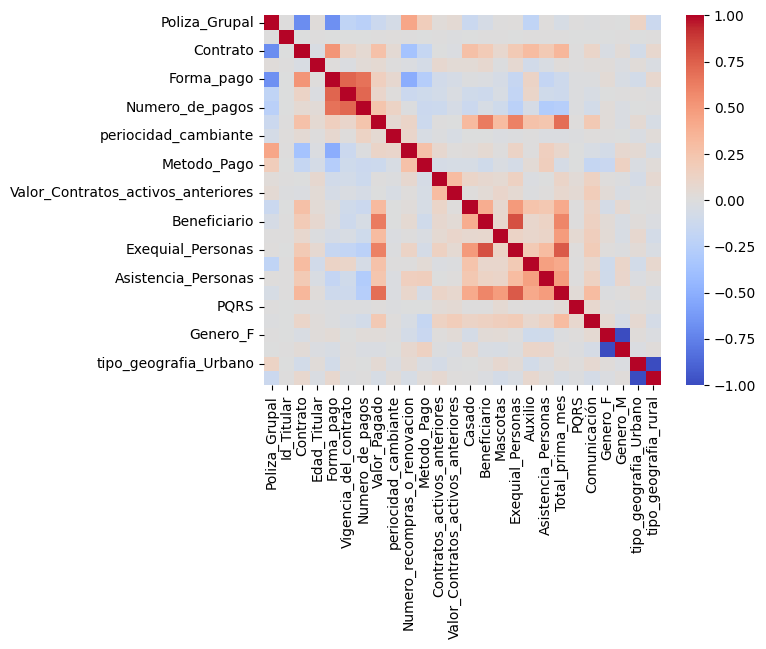

In [46]:
# Crear una matriz de correlación para el conjunto de datos
correlation_matrix = df.corr(numeric_only=True)
# Crear un mapa de calor para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)

<Figure size 1600x1200 with 0 Axes>

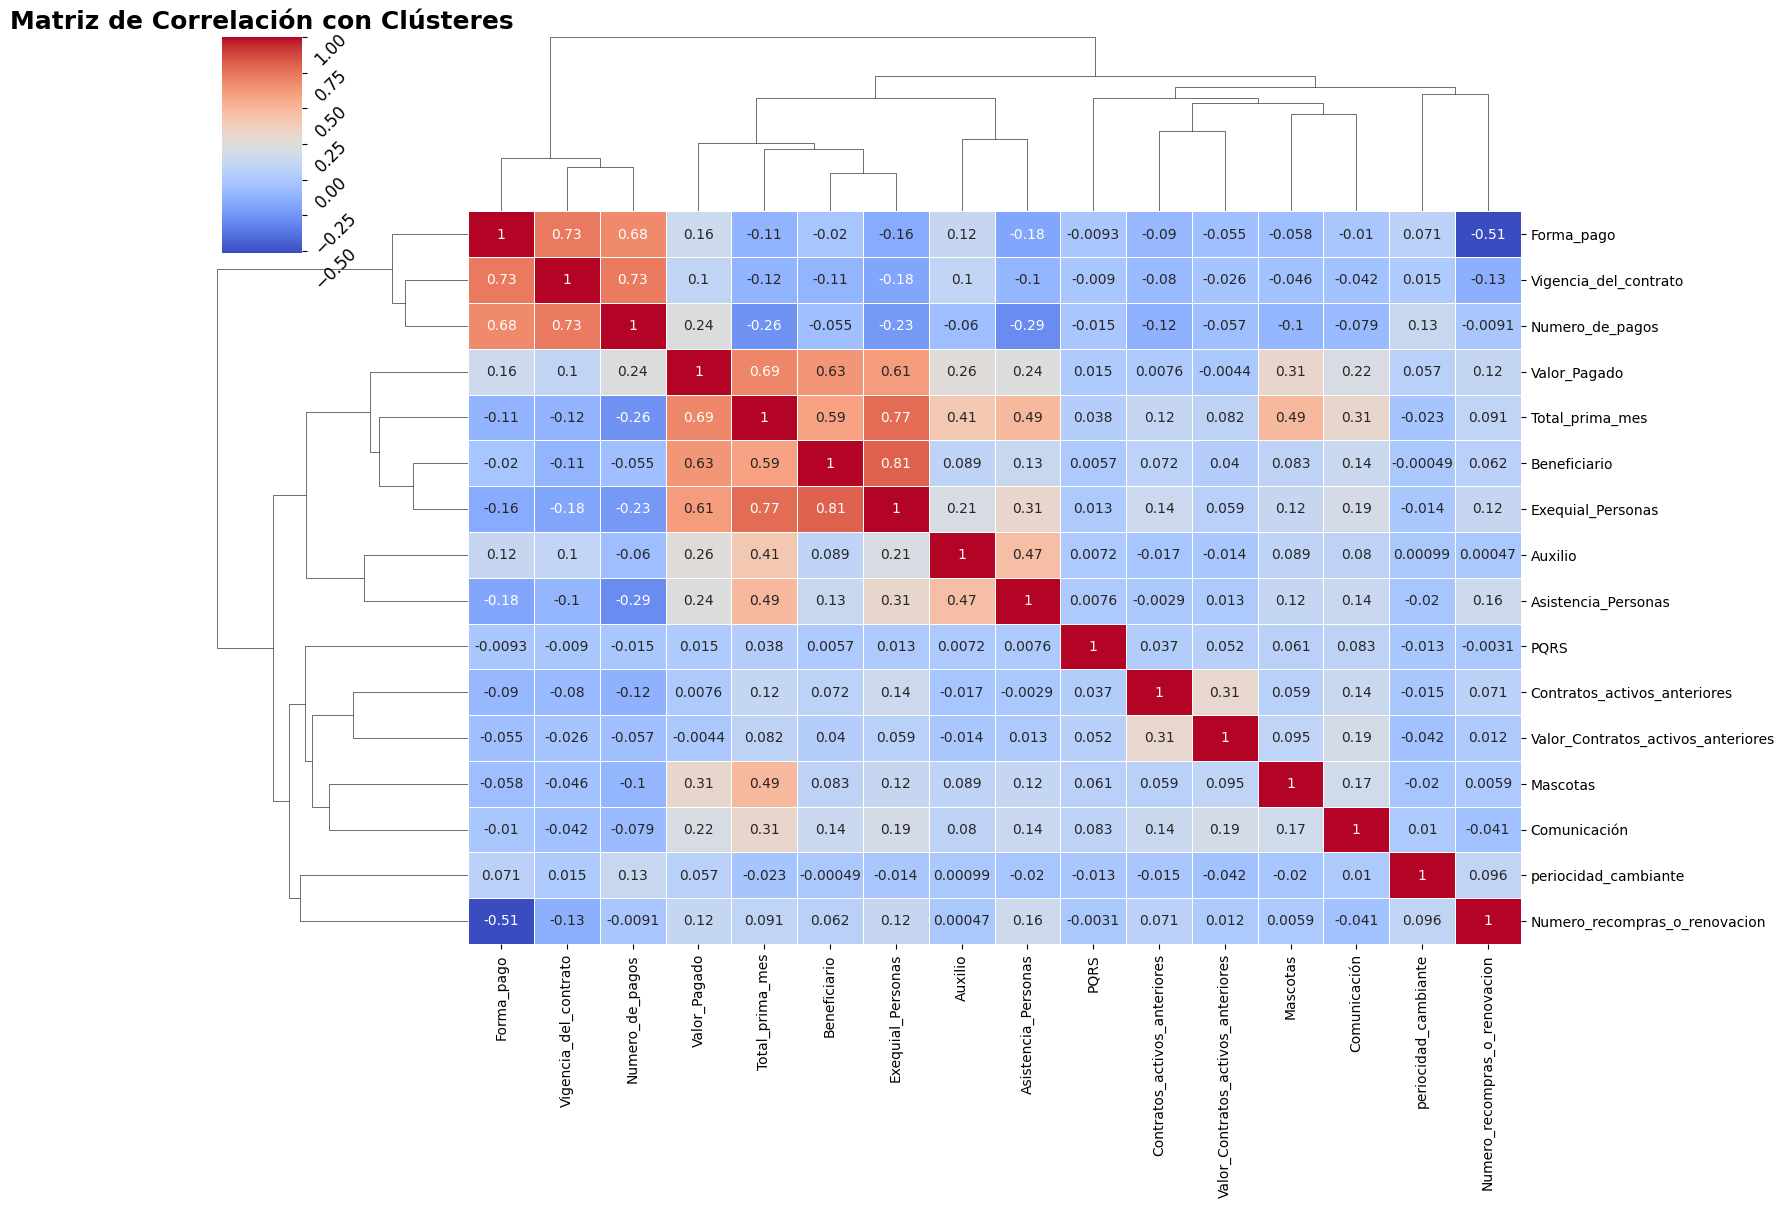

In [47]:

plt.figure(figsize=(16, 12))
# Clustermap
sns.clustermap(df[numCols].corr(), annot=True, cmap='coolwarm', figsize=(16, 12), linewidths=0.5)
plt.title('Matriz de Correlación con Clústeres', fontsize=18, weight='bold')

# Ajustar el tamaño de las etiquetas de los ejes (para que se vean mejor si son muchas)
plt.xticks(fontsize=12, rotation=45)  # Rotar etiquetas del eje X
plt.yticks(fontsize=12, rotation=45)  # Rotar etiquetas del eje Y

plt.show()

